# Libraries imported

In [6]:
from urllib.request import urlopen
import json
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load dataset

In [7]:
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2022-09-25&endtime=2022-11-01'
json_obj = urlopen(url)
data = json.load(json_obj)
df = pd.json_normalize(data, record_path=['features'])

# Transforming dataset

In [8]:
df = df[['properties.time', 'properties.place', 'properties.mag', 'properties.magType', 'geometry.coordinates', 'properties.tsunami']]

df.rename(columns={'properties.time' : 'time',
                          'properties.place' : 'place',
                          'properties.mag' : 'mag',
                          'properties.magType' : 'magType',
                          'geometry.coordinates' : 'coordinates',
                          'properties.tsunami' : 'tsunami'}, inplace=True)

df_locations = pd.DataFrame(df["coordinates"].to_list(), columns=['longitude', 'latitude', 'depth'])
df['latitude'] = df_locations.latitude
df['longitude'] = df_locations.longitude
df['depth'] = df_locations.depth
df.drop(columns='coordinates', inplace=True)

df.time = pd.to_datetime(df.time, unit='ms')

In [9]:
df['year'] = df.time.dt.year # Creating a year feature
df['month'] = df.time.dt.month # Creating a month feature
df.drop(columns=['time', 'year'], inplace=True) 
df[['km', 'location']] = df['place'].str.split(',', 1, expand=True) # spliting the region from the aproximate location
df.location.fillna(df.km[df.km.str.contains('km') == False], inplace=True) # Filling the locations that didn't had km aproximations
no_location = df[df.location.isna()].index
df.drop(no_location, inplace=True)
df.drop(columns=['place'], inplace=True)

C:\Users\Auli\AppData\Local\Temp\ipykernel_5972\2334046914.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['km', 'location']] = df['place'].str.split(',', 1, expand=True) # spliting the region from the aproximate location


In [10]:
df.location.fillna(df.km[df.km.str.contains('km') == False], inplace=True)
df.drop(columns='km', inplace=True)
df.drop(columns='tsunami', inplace=True)

In [13]:
df

,mag,magType,latitude,longitude,depth,month,location
0,2.30,ml,61.089900,-152.313200,108.700000,10,Alaska
1,0.30,ml,39.345100,-119.960300,4.900000,10,California
2,1.90,ml,53.485200,-165.266800,40.500000,10,Alaska
3,4.20,mb,5.461800,126.631000,67.437000,10,Philippines
4,2.01,md,19.188667,-155.397995,32.049999,10,Hawaii
...,...,...,...,...,...,...,...
15737,2.50,md,17.948000,-66.914167,13.030000,9,Puerto Rico
15738,1.50,ml,59.957700,-147.363000,19.700000,9,Alaska
15739,1.60,ml,37.094000,-115.766600,8.700000,9,Nevada
15740,0.91,md,38.840500,-122.808000,2.390000,9,CA


# Encoding object fields

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
mappings_magtype = []

encoder = LabelEncoder()

df.magType = encoder.fit_transform(df.magType)
mappings_dict = {index : label for index, label in enumerate(encoder.classes_)}
mappings_magtype.append(mappings_dict)

mappings_location = []

encoder = LabelEncoder()

df.location = encoder.fit_transform(df.location)
mappings_dict = {index : label for index, label in enumerate(encoder.classes_)}
mappings_location.append(mappings_dict)

In [16]:
df

,mag,magType,latitude,longitude,depth,month,location
0,2.30,4,61.089900,-152.313200,108.700000,10,1
1,0.30,4,39.345100,-119.960300,4.900000,10,17
2,1.90,4,53.485200,-165.266800,40.500000,10,1
3,4.20,0,5.461800,126.631000,67.437000,10,78
4,2.01,2,19.188667,-155.397995,32.049999,10,37
...,...,...,...,...,...,...,...
15737,2.50,2,17.948000,-66.914167,13.030000,9,79
15738,1.50,4,59.957700,-147.363000,19.700000,9,1
15739,1.60,4,37.094000,-115.766600,8.700000,9,63
15740,0.91,2,38.840500,-122.808000,2.390000,9,16


# Scale Data

In [17]:
for col in df.columns:
    avg = df[col].mean()
    sd = df[col].std()
    df[col] = df[col].apply(lambda x: (x-avg/sd))
df

,mag,magType,latitude,longitude,depth,month,location
0,0.962753,1.766612,58.979016,-150.561085,108.214596,-15.656362,0.228282
1,-1.037247,1.766612,37.234216,-118.208185,4.414596,-15.656362,16.228282
2,0.562753,1.766612,51.374316,-163.514685,40.014596,-15.656362,0.228282
3,2.862753,-2.233388,3.350916,128.383115,66.951596,-15.656362,77.228282
4,0.672753,-0.233388,17.077783,-153.645880,31.564595,-15.656362,36.228282
...,...,...,...,...,...,...,...
15737,1.162753,-0.233388,15.837116,-65.162051,12.544596,-16.656362,78.228282
15738,0.162753,1.766612,57.846816,-145.610885,19.214596,-16.656362,0.228282
15739,0.262753,1.766612,34.983116,-114.014485,8.214596,-16.656362,62.228282
15740,-0.427247,-0.233388,36.729616,-121.055885,1.904596,-16.656362,15.228282


In [20]:
no_mag = df[df.mag.isna()].index
df.drop(no_mag, inplace=True)

# Implementing DBSCAN

In [56]:
min_samples = df.shape[1]*2
dbscan = DBSCAN(eps=0.2, min_samples=25)
clusters = dbscan.fit_predict(df)
print(f'Clusters created: {str(list(set(clusters)))}')

Clusters created: [0, 1, 2, 3, 4, 5, -1]


# Implementing DBSCAN with Elbow Method

In [22]:
k = min_samples if min_samples > 2 else 2
nbrs = NearestNeighbors(n_neighbors=k).fit(df)
distances, indices = nbrs.kneighbors(df)

In [25]:
print(f'Min samples: {str(min_samples)}')
print(f'Shape of distances matrix: {str(distances.shape)}')
for enum, row in enumerate(distances[:5]):
    print(f'Observation {str(enum)} : {str([round(x, 2) for x in row])}')

Min samples: 14
Shape of distances matrix: (15312, 14)
Observation 0 : [0.0, 1.0, 1.05, 1.14, 1.33, 1.33, 1.37, 1.41, 1.47, 1.49, 1.59, 1.7, 1.71, 1.74]
Observation 1 : [0.0, 0.41, 0.57, 0.6, 0.8, 0.86, 0.86, 0.99, 1.01, 1.02, 1.1, 1.29, 1.33, 1.43]
Observation 2 : [0.0, 0.81, 1.0, 1.31, 1.51, 1.63, 1.65, 2.09, 2.85, 3.27, 3.79, 4.17, 4.2, 4.34]
Observation 3 : [0.0, 0.99, 2.78, 5.63, 5.81, 8.75, 9.01, 9.75, 11.06, 14.05, 14.96, 15.94, 20.88, 22.63]
Observation 4 : [0.0, 0.08, 0.11, 0.11, 0.13, 0.13, 0.14, 0.14, 0.21, 0.24, 0.24, 0.25, 0.25, 0.25]


In [26]:
df['knn_farthest_dist'] = distances[:, 1]
df

,mag,magType,latitude,longitude,depth,month,location,knn_farthest_dist
0,0.962753,1.766612,58.979016,-150.561085,108.214596,-15.656362,0.228282,1.003331
1,-1.037247,1.766612,37.234216,-118.208185,4.414596,-15.656362,16.228282,0.412430
2,0.562753,1.766612,51.374316,-163.514685,40.014596,-15.656362,0.228282,0.811578
3,2.862753,-2.233388,3.350916,128.383115,66.951596,-15.656362,77.228282,0.985945
4,0.672753,-0.233388,17.077783,-153.645880,31.564595,-15.656362,36.228282,0.083766
...,...,...,...,...,...,...,...,...
15737,1.162753,-0.233388,15.837116,-65.162051,12.544596,-16.656362,78.228282,0.206431
15738,0.162753,1.766612,57.846816,-145.610885,19.214596,-16.656362,0.228282,1.068612
15739,0.262753,1.766612,34.983116,-114.014485,8.214596,-16.656362,62.228282,0.781053
15740,-0.427247,-0.233388,36.729616,-121.055885,1.904596,-16.656362,15.228282,0.082962


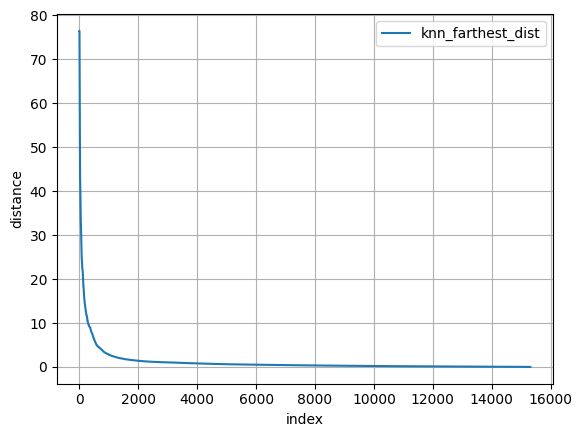

In [27]:
df.sort_values('knn_farthest_dist', ascending=False).reset_index()[['knn_farthest_dist']].plot()
plt.xlabel('index')
plt.ylabel('distance')
plt.grid(True)
plt.show()

In [29]:
km = DBSCAN(eps=5, min_samples=min_samples)
df['cluster'] = km.fit_predict(df)
df.cluster.value_counts()

 0     5025
 1     4042
-1     1793
 4      568
 3      563
 2      502
 8      486
 11     334
 12     281
 6      237
 31     235
 10     163
 20     142
 7      117
 27     105
 9       90
 29      63
 15      56
 14      47
 5       45
 24      39
 19      39
 18      36
 13      35
 17      34
 28      33
 21      32
 23      25
 33      24
 16      21
 25      19
 26      19
 32      18
 22      15
 30      15
 34      14
Name: cluster, dtype: int64

# Visualizing clusters

In [31]:
from sklearn.decomposition import PCA

In [57]:
pca = PCA(n_components=2)
reduced_X = pd.DataFrame(pca.fit_transform(df), columns=['PC1', 'PC2'])
reduced_X

,PC1,PC2
0,-41.083037,89.270493
1,-14.333647,-17.173150
2,-59.336351,23.142220
3,242.764223,18.873886
4,-31.505965,11.172336
...,...,...
15307,63.019220,-20.006686
15308,-46.741756,0.858268
15309,9.109880,-18.588508
15310,-17.474323,-19.296645


In [58]:
reduced_X['cluster'] = clusters
reduced_X

,PC1,PC2,cluster
0,-41.083037,89.270493,-1
1,-14.333647,-17.173150,-1
2,-59.336351,23.142220,-1
3,242.764223,18.873886,-1
4,-31.505965,11.172336,-1
...,...,...,...
15307,63.019220,-20.006686,-1
15308,-46.741756,0.858268,-1
15309,9.109880,-18.588508,-1
15310,-17.474323,-19.296645,-1


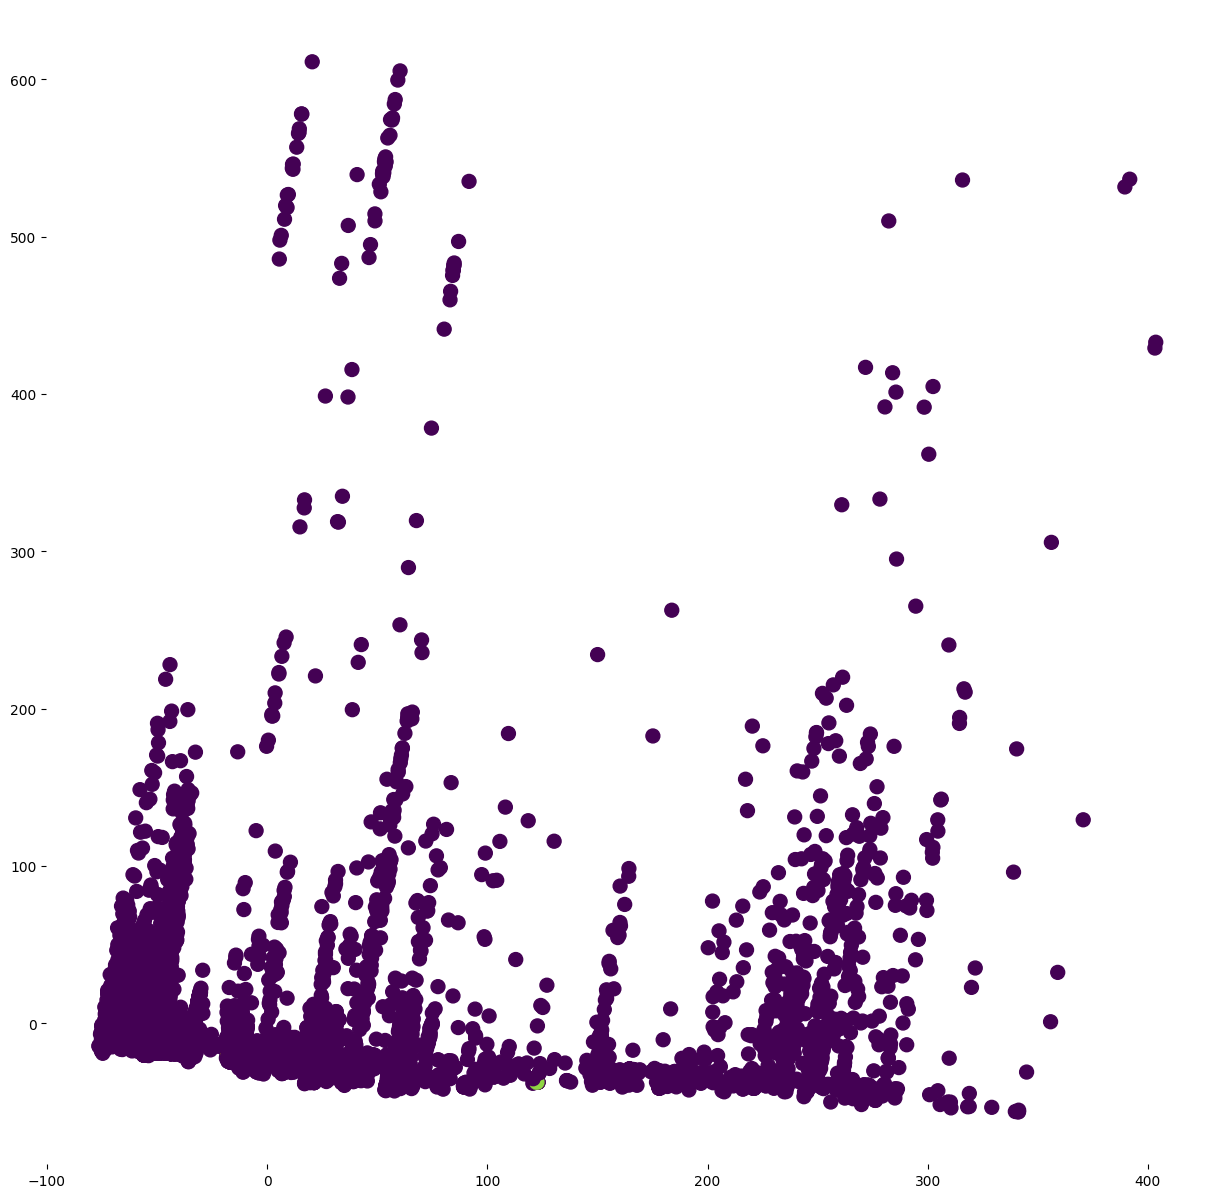

In [59]:
plt.figure(figsize=(15, 15))
plt.scatter(reduced_X.iloc[:,0], reduced_X.iloc[:,1], c=clusters, s=100)
plt.box(False)
plt.show()